<a href="https://colab.research.google.com/github/AHamamd150/MLscan_group/blob/main/MLS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
# from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
import os
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
import warnings
## check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found.....')
#sys.exit()
else:
    print('Default GPU device :{}'.format(tf.test.gpu_device_name()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: No GPU found.....
  app.launch_new_instance()


In [ ]:
class scan():
    def __init__(self,LL,function_dim,th_value,standard_deviation):
      self.th_value = th_value
      self.standard_deviation = standard_deviation
      self.LL=LL
      self.function_dim = function_dim 
    
    def obs(self,x):
        #F = (2+np.cos(x[:,0]/2)*np.cos(x[:,1]/2))**5
        F = (2+np.cos(x[:,0]/7)*np.cos(x[:,1]/7)*np.cos(x[:,2]/7))**5
        return np.array(F)

    def generate_init(self,n,r1,r2):
        return np.random.uniform(r1,r2, size=(n,self.function_dim))

    def likelihood(self,exp_value,std,th):
        ll = np.exp(- (exp_value - th)**2/(2*std**2))
        return ll

    def run_DNN(self,runs=20,neurons = 100,activation='relu',epoch=1000,batch_size=500,batch_L=1000,batch_K=100,print_output=True):
        dnn = Sequential()
        dnn.add(Dense(neurons, input_shape=(self.function_dim,)))
        dnn.add(Dense(neurons, activation=activation))
        dnn.add(Dense(neurons, activation=activation))
        dnn.add(Dense(neurons, activation=activation))
        dnn.add(Dense(neurons, activation=activation))
        dnn.add(Dense(1))

        dnn.compile(optimizer='adam', loss='mse')    
        Xf=self.generate_init(batch_K,-10*np.pi,10*np.pi)
        obsf = self.obs(Xf)
        dnn.fit(Xf, obsf, epochs=epoch, verbose=0)
        X = np.empty(shape=[0,self.function_dim]) 
        obs1 = np.empty(shape=[0,1])
        for q in range(runs):
            x = self.generate_init(batch_L,-10*np.pi,10*np.pi)
            pred = dnn.predict(x).flatten()
            pred1 = self.likelihood(self.th_value,self.standard_deviation,pred)
            xsel = x[pred1>self.LL]           
            xsel1 = np.append(xsel[:round(batch_K*0.9)],x[-round(batch_K*0.1):],axis=0)
            obs2 = self.obs(xsel1)
            X = np.append(X, xsel1, axis=0)
            obs1 = np.append(obs1, obs2)
            dnn.fit(X, obs1,epochs=epoch,batch_size=batch_size, verbose=0)
            if print_output == True:
                print('DNN_model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
        return X


    def run_GBR(self,runs=20,learning_rate=0.01,n_estimators=100,max_depth=30,batch_L=1000,batch_K=100,print_output=True):
        GBR =GradientBoostingRegressor(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)
        Xf=self.generate_init(batch_K,-10*np.pi,10*np.pi)
        obsf = self.obs(Xf)
        GBR.fit(Xf, obsf)
        X = np.empty(shape=[0,self.function_dim]) 
        obs1 = np.empty(shape=[0,1])
        for q in range(runs):
            x = self.generate_init(batch_L,-10*np.pi,10*np.pi)
            pred = GBR.predict(x).flatten()
            pred1 = self.likelihood(self.th_value,self.standard_deviation,pred)
            xsel = x[pred1>self.LL]           
            xsel1 = np.append(xsel[:round(batch_K*0.9)],x[-round(batch_K*0.1):],axis=0)
            obs2 = self.obs(xsel1)
            X = np.append(X, xsel1, axis=0)
            obs1 = np.append(obs1, obs2)
            GBR.fit(X, obs1)
            if print_output == True:
                print('DNN_model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
        return X
    
    def run_RFR(self,runs=20,learning_rate=0.01,n_estimators=100,max_depth=30,batch_L=1000,batch_K=100,print_output=True):
        RFR =RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth)
        Xf=self.generate_init(batch_K,-10*np.pi,10*np.pi)
        obsf = self.obs(Xf)
        RFR.fit(Xf, obsf)
        X = np.empty(shape=[0,self.function_dim]) 
        obs1 = np.empty(shape=[0,1])
        for q in range(runs):
            x = self.generate_init(batch_L,-10*np.pi,10*np.pi)
            pred = RFR.predict(x).flatten()
            pred1 = self.likelihood(self.th_value,self.standard_deviation,pred)
            xsel = x[pred1>self.LL]           
            xsel1 = np.append(xsel[:round(batch_K*0.9)],x[-round(batch_K*0.1):],axis=0)
            obs2 = self.obs(xsel1)
            X = np.append(X, xsel1, axis=0)
            obs1 = np.append(obs1, obs2)
            RFR.fit(X, obs1)
            if print_output == True:
                print('DNN_model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
        return X


    def run_SVMRBF(self,runs=20,learning_rate=0.01,runs =20, C=100, gamma=0.1, epsilon=0.1,batch_L=1000,batch_K=100,print_output=True):
        SVMRBF = SVR(kernel="rbf", C=C, gamma=gamma, epsilon=epsilon)
        Xf=self.generate_init(batch_K,-10*np.pi,10*np.pi)
        obsf = self.obs(Xf)
        SVMRBF.fit(Xf, obsf)
        X = np.empty(shape=[0,self.function_dim]) 
        obs1 = np.empty(shape=[0,1])
        for q in range(runs):
            x = self.generate_init(batch_L,-10*np.pi,10*np.pi)
            pred = SVMRBF.predict(x).flatten()
            pred1 = self.likelihood(self.th_value,self.standard_deviation,pred)
            xsel = x[pred1>self.LL]           
            xsel1 = np.append(xsel[:round(batch_K*0.9)],x[-round(batch_K*0.1):],axis=0)
            obs2 = self.obs(xsel1)
            X = np.append(X, xsel1, axis=0)
            obs1 = np.append(obs1, obs2)
            SVMRBF.fit(X, obs1)
            if print_output == True:
                print('DNN_model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
        return X


    def run_SVMPOLY(self,runs =20,degree=3, C=100, gamma=0.1, epsilon=0.1,batch_L=1000,batch_K=100,print_output=True):
        SVMPOLY = SVR(kernel="poly", degree=degree, C=C, gamma=gamma, epsilon=epsilon)
        Xf=self.generate_init(batch_K,-10*np.pi,10*np.pi)
        obsf = self.obs(Xf)
        SVMPOLY.fit(Xf, obsf)
        X = np.empty(shape=[0,self.function_dim]) 
        obs1 = np.empty(shape=[0,1])
        for q in range(runs):
            x = self.generate_init(batch_L,-10*np.pi,10*np.pi)
            pred = SVMPOLY.predict(x).flatten()
            pred1 = self.likelihood(self.th_value,self.standard_deviation,pred)
            xsel = x[pred1>self.LL]           
            xsel1 = np.append(xsel[:round(batch_K*0.9)],x[-round(batch_K*0.1):],axis=0)
            obs2 = self.obs(xsel1)
            X = np.append(X, xsel1, axis=0)
            obs1 = np.append(obs1, obs2)
            SVMPOLY.fit(X, obs1)
            if print_output == True:
                print('DNN_model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
        return X    
    def plot_model(self,input,title=''):
        plt.figure(figsize=(4,4))
        plt.scatter(input[:, 0],input[:, 1],s=1)
        plt.xlabel(r'$X_1$',fontsize=10);
        plt.ylabel(r'$X_2$',fontsize=10);
        plt.title(title,fontsize=10)
        c = plt.colorbar(orientation="horizontal");
        c.set_label('likelihood',size=10);


In [ ]:
model = scan(LL=0.9,function_dim=3,th_value=100,standard_deviation=20)

In [ ]:
output_dd =model.run_DNN(runs=30,neurons = 100,activation='relu',batch_K=500,batch_L=50000,print_output=True)
output_GB =model.run_GBR(runs=40,n_estimators=100,print_output=False)
output_RBF =model.run_SVMRBF(runs=50,print_output=True)
output_POLY =model.run_SVMPOLY(runs =5,degree=2, C=1, gamma=0.1, epsilon=0.1,print_output=True)
output_rf =model.run_RFR(runs=20,n_estimators=200,print_output=True)


DNN_model- Run Number 0 - Number of collected points= 500
DNN_model- Run Number 1 - Number of collected points= 1000
DNN_model- Run Number 2 - Number of collected points= 1500
DNN_model- Run Number 3 - Number of collected points= 2000
DNN_model- Run Number 4 - Number of collected points= 2500
DNN_model- Run Number 5 - Number of collected points= 3000
DNN_model- Run Number 6 - Number of collected points= 3500
DNN_model- Run Number 7 - Number of collected points= 4000
DNN_model- Run Number 8 - Number of collected points= 4500
DNN_model- Run Number 9 - Number of collected points= 5000
DNN_model- Run Number 10 - Number of collected points= 5500
DNN_model- Run Number 11 - Number of collected points= 6000
DNN_model- Run Number 12 - Number of collected points= 6500
DNN_model- Run Number 13 - Number of collected points= 7000
DNN_model- Run Number 14 - Number of collected points= 7500
DNN_model- Run Number 15 - Number of collected points= 8000
DNN_model- Run Number 16 - Number of collected poin

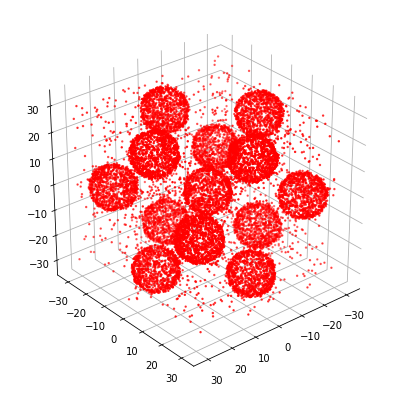

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

ax.scatter(output_dd[:,0],output_dd[:,1],output_dd[:,2],s=2,color='red');
#ax.scatter(x1[pred>0.9],x2[pred>0.9],x3[pred>0.9],color='b',s=1,alpha=0.3);

ax.view_init(30, 50);

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid()